In [88]:
import scipy.io as scio
import hdf5storage
import numpy as np
import matplotlib.pyplot as plt
import math

In [77]:
data = hdf5storage.loadmat('./data/indy_20160407_02.mat')

In [78]:
data.keys()

dict_keys(['chan_names', 'cursor_pos', 'finger_pos', 'spikes', 't', 'target_pos', 'wf'])

In [79]:
print(data['chan_names'].shape,
      data['cursor_pos'].shape,
      data['finger_pos'].shape,
      data['spikes'].shape,
      data['t'].shape,
      data['target_pos'].shape,
      data['wf'].shape)
      

(192, 1) (204446, 2) (204446, 3) (192, 3) (204446, 1) (204446, 2) (192, 3)


In [80]:
max_len = -1
max_c = -1

for i in range(len(data['spikes'])):
    seq = data['spikes'][i, 1]
    if len(seq) > max_len:
        max_c = i
        max_len = len(seq)

print(max_c)

112


In [69]:
print(data['wf'][112, 1].shape)

(20584, 48)


In [81]:
neuron_id = 1
channel = 112


def search_nearest_timestamp(t, s):
    '''
        return: the nearest indices in t for each element in s
    '''
    chunk_size = 500
    ans = np.array([])
    for i in range(len(s)//chunk_size+1):
        start_idx = i * chunk_size
        end_idx   = min((i+1)*chunk_size, len(s))
        chunk = s[start_idx:end_idx]
        diff = np.abs(chunk - t.T)
        ans = np.concatenate([ans, np.argmin(diff, axis=1)])
    return ans.astype(np.int)


# [T, 1]
spikes_timestamp = data['spikes'][channel, neuron_id]
spikes_timestamp_indices = search_nearest_timestamp(data['t'], spikes_timestamp)

# [T, C]
spikes = data['wf'][channel, neuron_id]

# [T, 2]
cursor_pos = data['cursor_pos'][spikes_timestamp_indices, :]
target_pos = data['target_pos'][spikes_timestamp_indices, :]

/tmp/ipykernel_284074/1673565934.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return ans.astype(np.int)


In [82]:
# Search for the indices where target change 
tgt_chg_indices = [0]

for i in range(1, len(target_pos)):
    if np.sum(target_pos[i] == target_pos[i-1]) != 2:
        tgt_chg_indices.append(i)

# Capture cursor shifts according to the above indices
cursor_shifts = np.zeros([len(tgt_chg_indices), 2])

tgt_chg_slices = []

for i in range(len(tgt_chg_indices)):
    start_idx = tgt_chg_indices[i]
    end_idx = tgt_chg_indices[i+1] if i < len(tgt_chg_indices) - 1 else -1
    cursor_shifts[i] = cursor_pos[end_idx] - cursor_pos[start_idx]
    tgt_chg_slices.append([start_idx, end_idx])

cursor_shifts_norms = np.linalg.norm(cursor_shifts, axis=1)

# keep shifts with norm > 1
cursor_shifts = cursor_shifts[cursor_shifts_norms>1]
tgt_chg_slices = np.array(tgt_chg_slices)[cursor_shifts_norms>1]
normed_cursor_shifts = cursor_shifts / np.linalg.norm(cursor_shifts, axis=1, keepdims=True)

# Eight reference directions
refer_dirc = np.array([[0., 1.],
                       [1./math.sqrt(2), 1./math.sqrt(2)],
                       [1., 0.],
                       [1./math.sqrt(2), -1./math.sqrt(2)],
                       [0., -1.],
                       [-1./math.sqrt(2), -1./math.sqrt(2)],
                       [-1., 0.],
                       [-1./math.sqrt(2), 1./math.sqrt(2)]])

# Compute cosine similarity
cos_sim = normed_cursor_shifts @ refer_dirc.T

# Compute the angle between shifts and reference directions
angles = np.arccos(cos_sim) / np.pi * 180

# Consider waves with only angle < 10
timestamps_slices_collection = [[] for i in range(8)]

for i in range(8):
    mask = (np.argmin(angles, axis=1)==i) * (np.min(angles, axis=1)<10)
    timestamps_slices_collection[i] = tgt_chg_slices[mask]


In [83]:
# Collect waves that corresponding to different motions

import bisect
import copy

# cut at 2 sec
thr = 2.

waves_collection = [[] for i in range(8)]

for i in range(8):
    index_slices = timestamps_slices_collection[i]
    for start, end in index_slices:
        wave = spikes[start:end]
        times = copy.deepcopy(spikes_timestamp[start:end])
        times -= times[0]

        end_idx = bisect.bisect_right(times, thr)
        wave = wave[:end_idx]
        times = times[:end_idx]

        waves_collection[i].append((times, wave))

## Raster

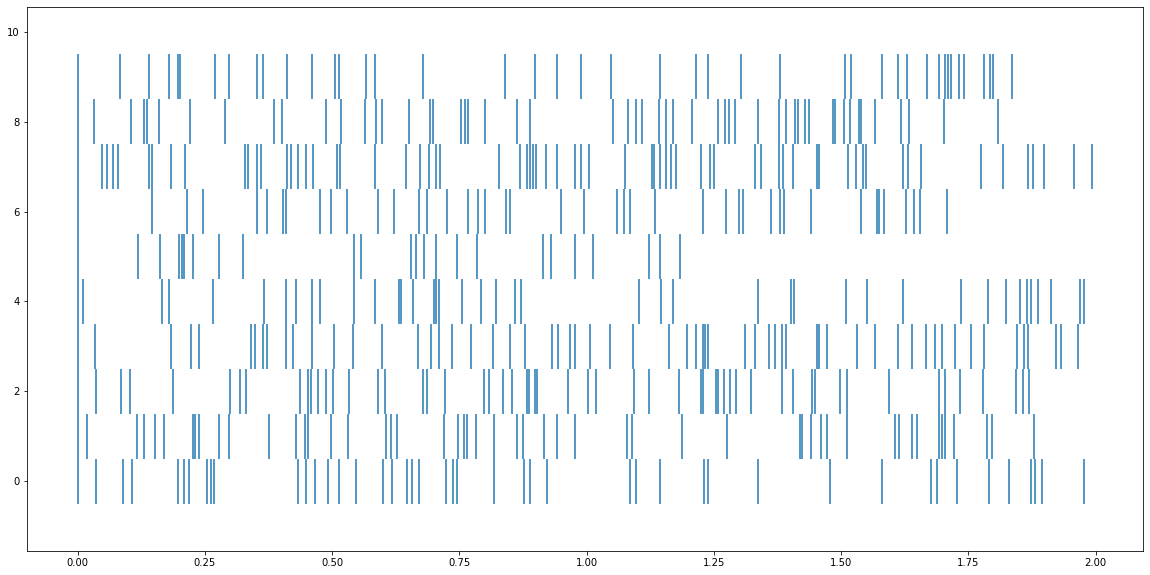

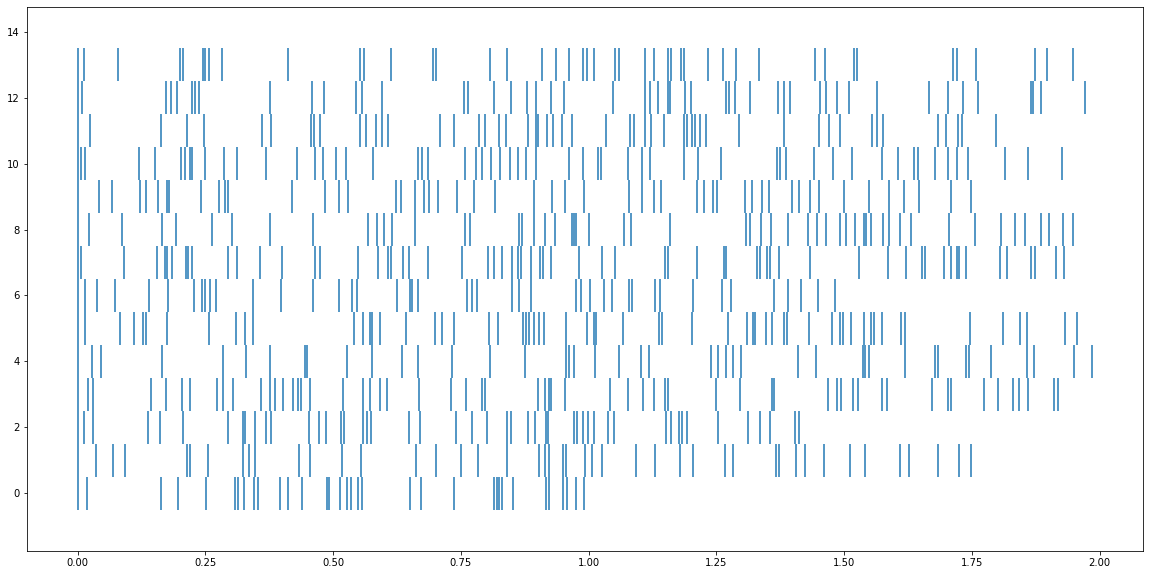

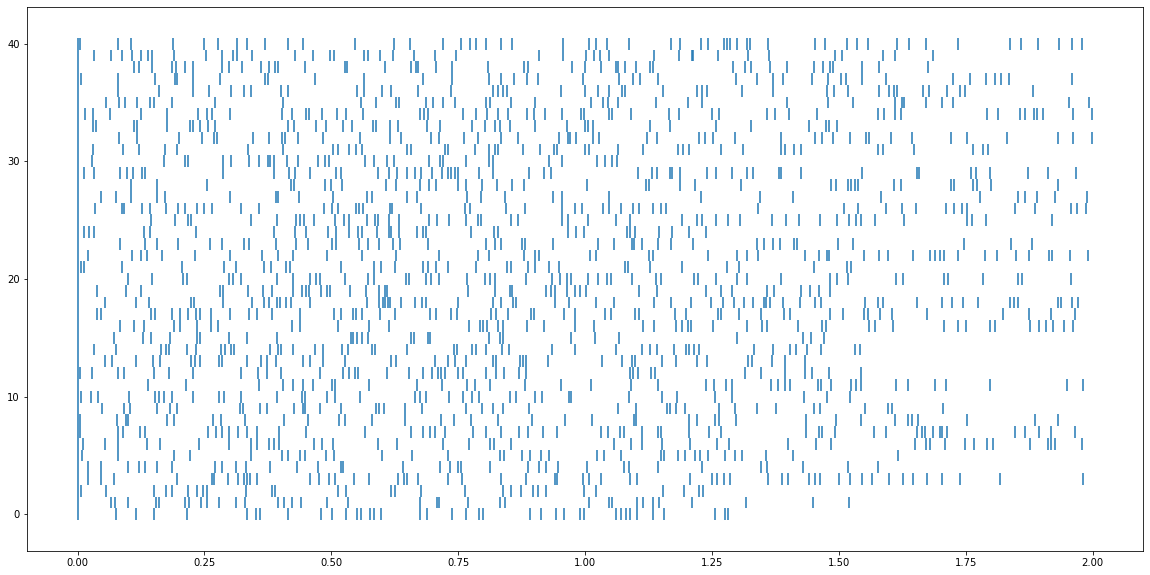

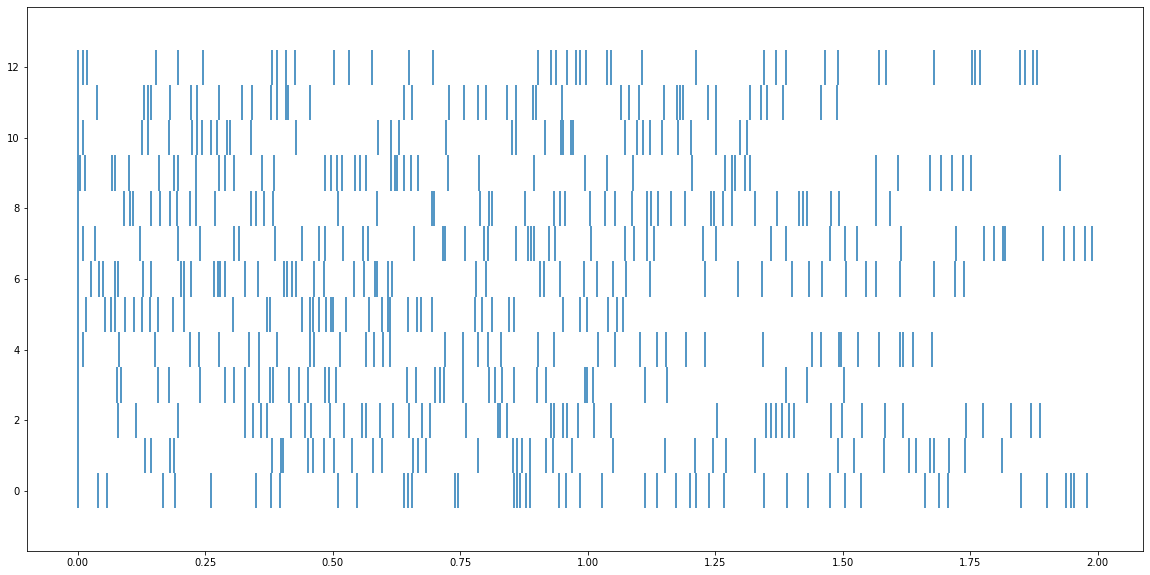

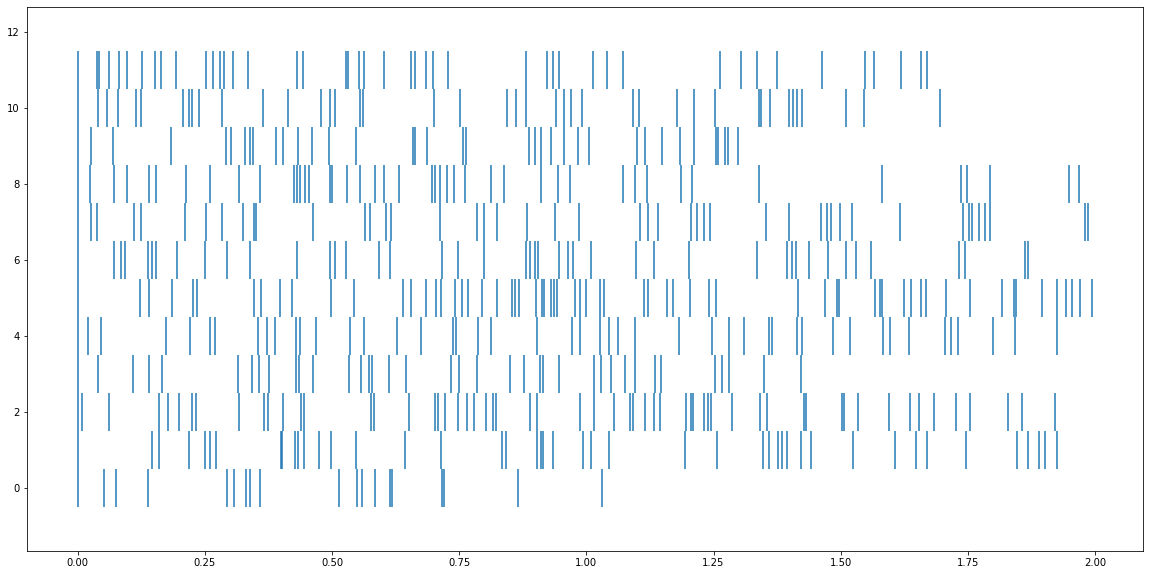

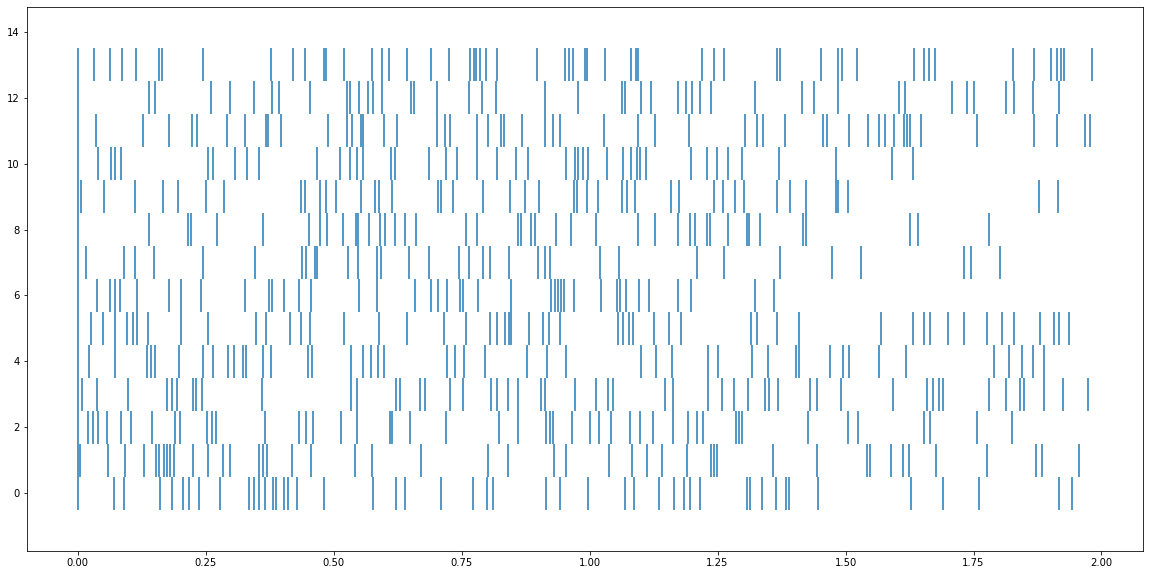

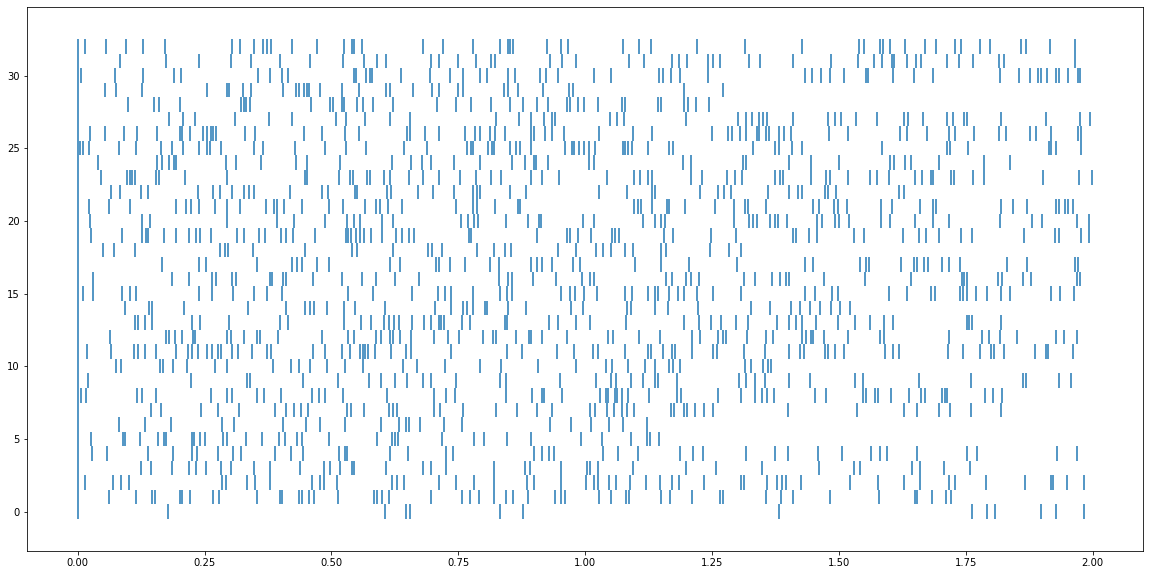

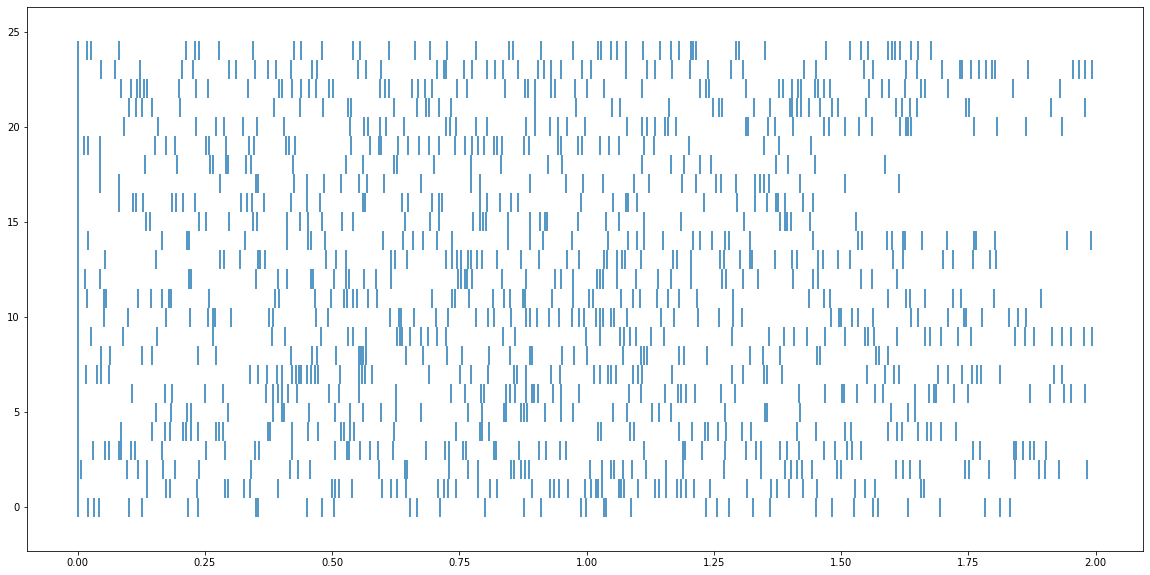

In [84]:
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import bisect

viz_channels = 6
sample_rate = 1e-2

dirc_map = {"up": 0,
            "up_right": 1,
            "right": 2,
            "down_right": 3,
            "down": 4,
            "down_left": 5,
            "left": 6,
            "up_left": 7}

# visualize the first viz_channels of each direction

for dirc, idx in dirc_map.items():

    motion_waves = waves_collection[idx]

    plt.figure(figsize=(20, 10))
    
    ts = [t[:, 0] for t, _ in motion_waves]
    plt.eventplot(ts)

    plt.savefig(f'./imgs/raster/{dirc}.jpg')


## PSTH

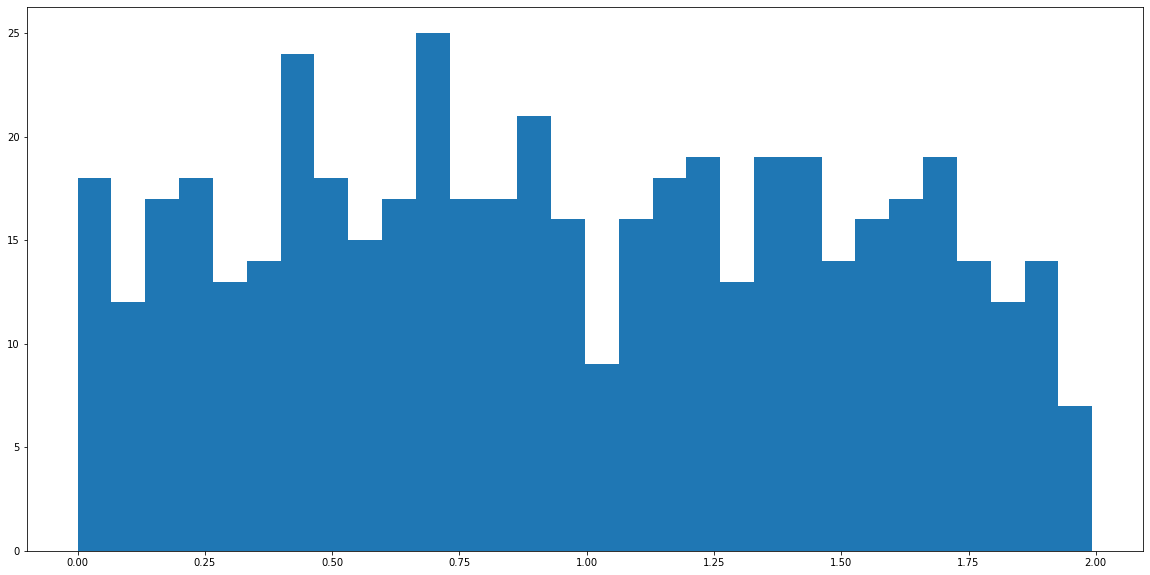

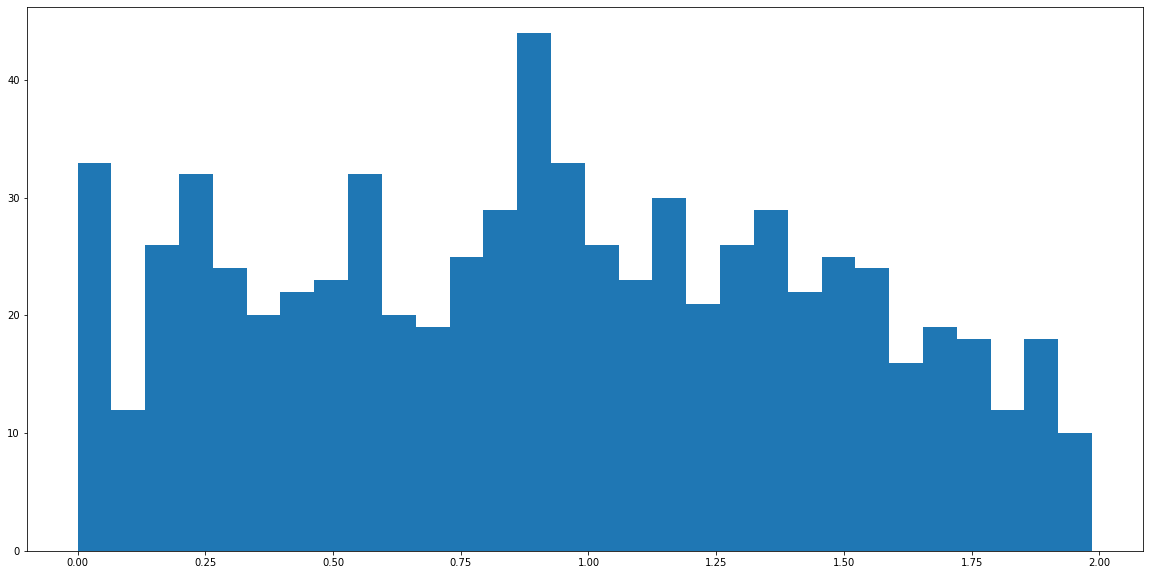

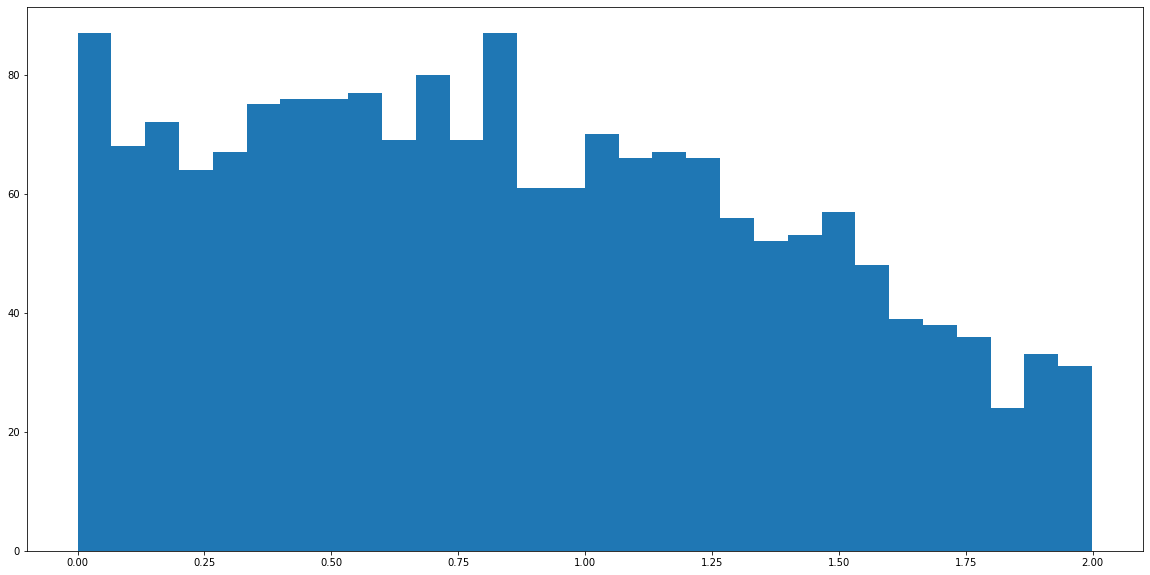

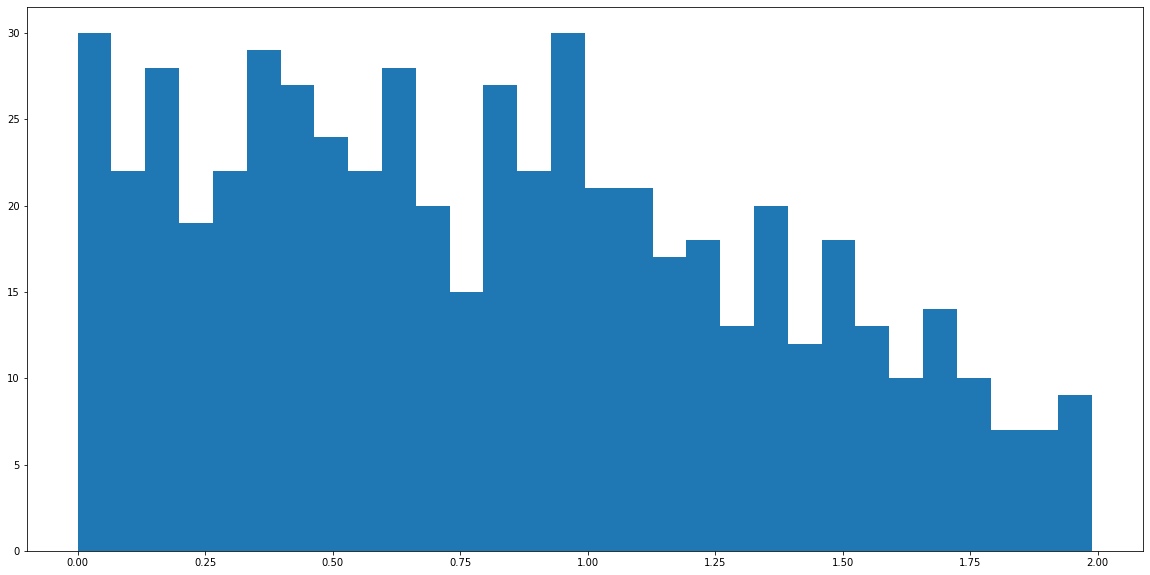

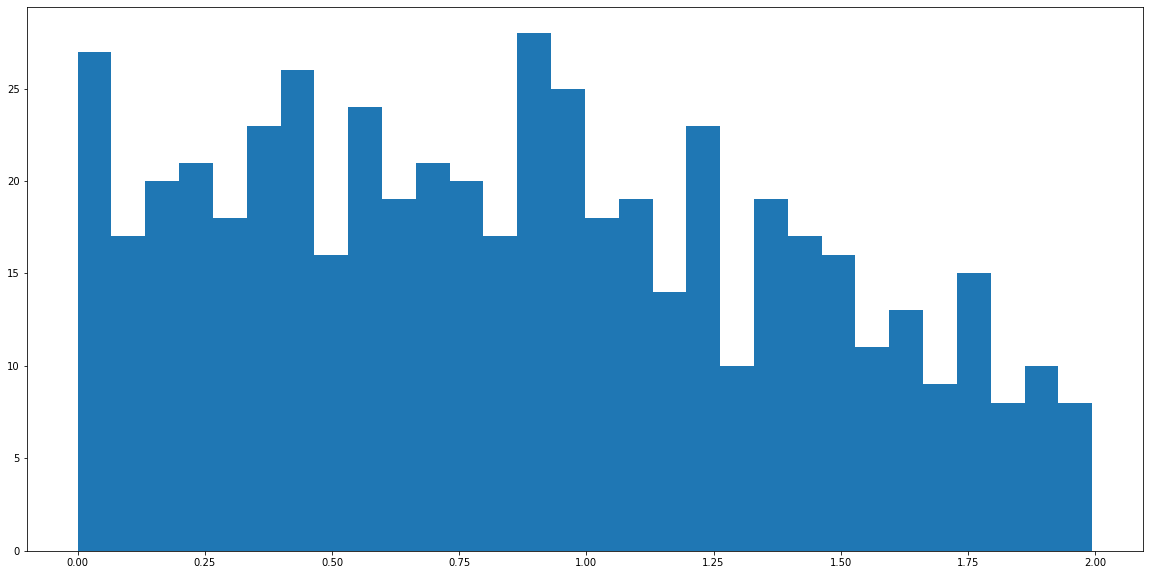

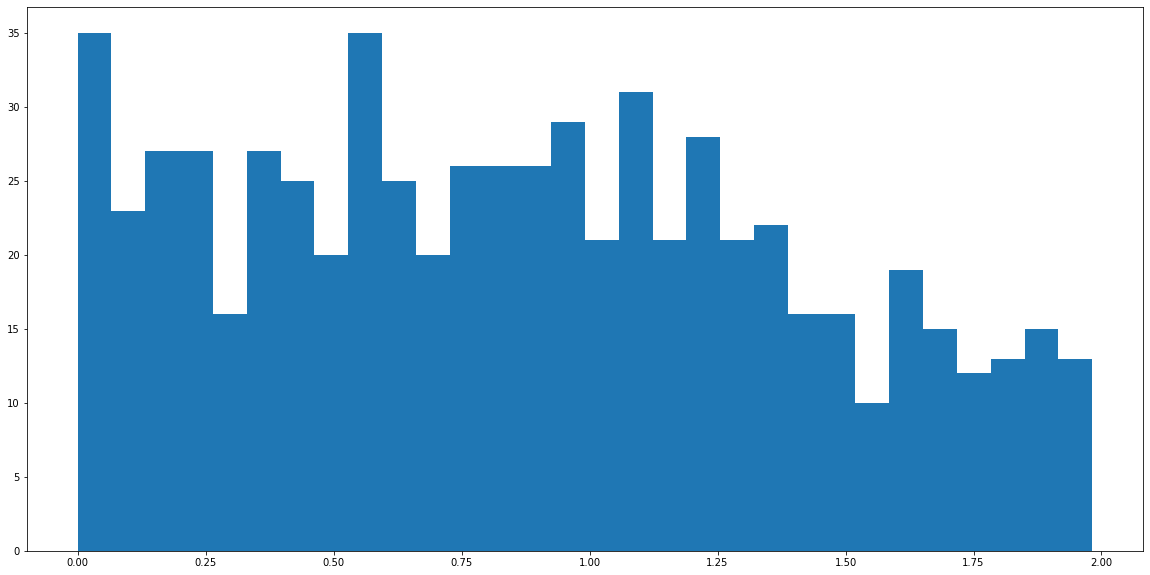

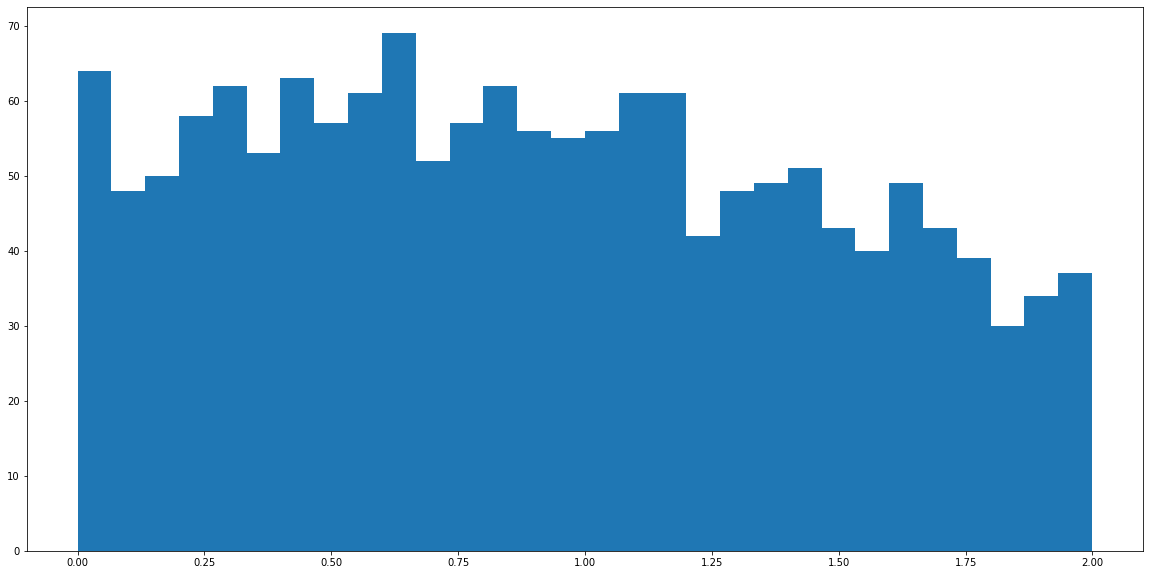

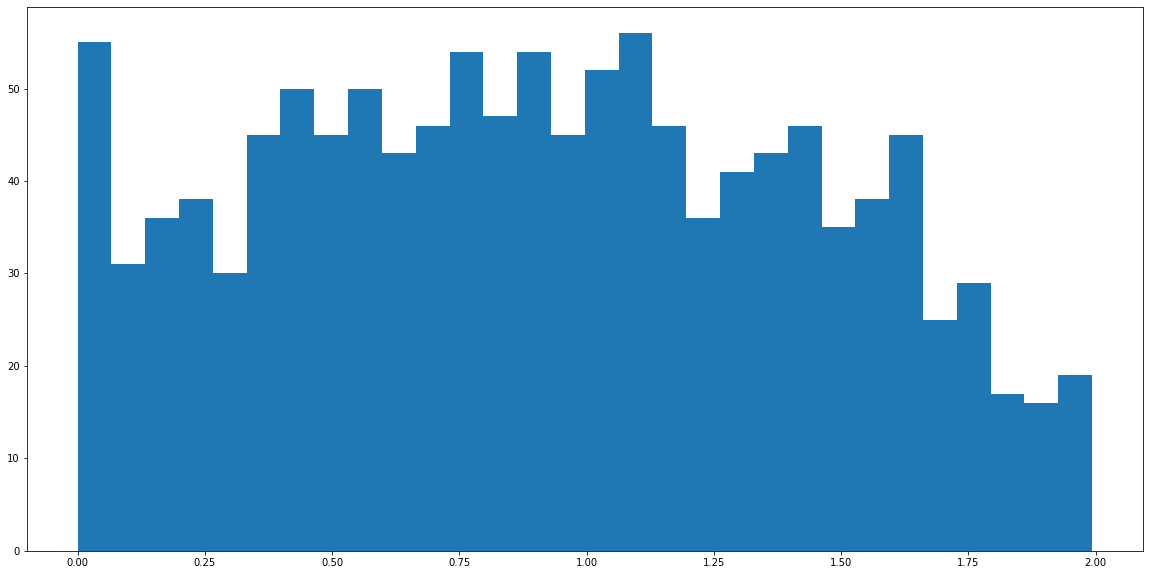

In [85]:
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema

viz_channels = 6
sample_rate = 1e-2

dirc_map = {"up": 0,
            "up_right": 1,
            "right": 2,
            "down_right": 3,
            "down": 4,
            "down_left": 5,
            "left": 6,
            "up_left": 7}

# visualize the first viz_channels of each direction

for dirc, idx in dirc_map.items():

    motion_waves = waves_collection[idx]

    plt.figure(figsize=(20, 10))
    
    # for c in range(viz_channels):
    #     spike_trains_timestamp = []
    #     for t, w in motion_waves:
    #         vis_w = w[:, c]
    #         t = t[:, 0]

    #         spike_idxs = argrelextrema(vis_w, np.greater)
    #         spike_trains_timestamp.extend(t[spike_idxs])
        
    #     plt.subplot(viz_channels, 1, c+1)
    #     plt.hist(spike_trains_timestamp, bins=50)

    spike_trains_timestamps = []
    for t, _ in motion_waves:
        spike_trains_timestamps.extend(t[:, 0])

    # print(spike_trains_timestamps)
    
    plt.hist(spike_trains_timestamps, bins=30)

    
    plt.savefig(f'./imgs/PSTH/{dirc}.jpg')

## Tuning Curve

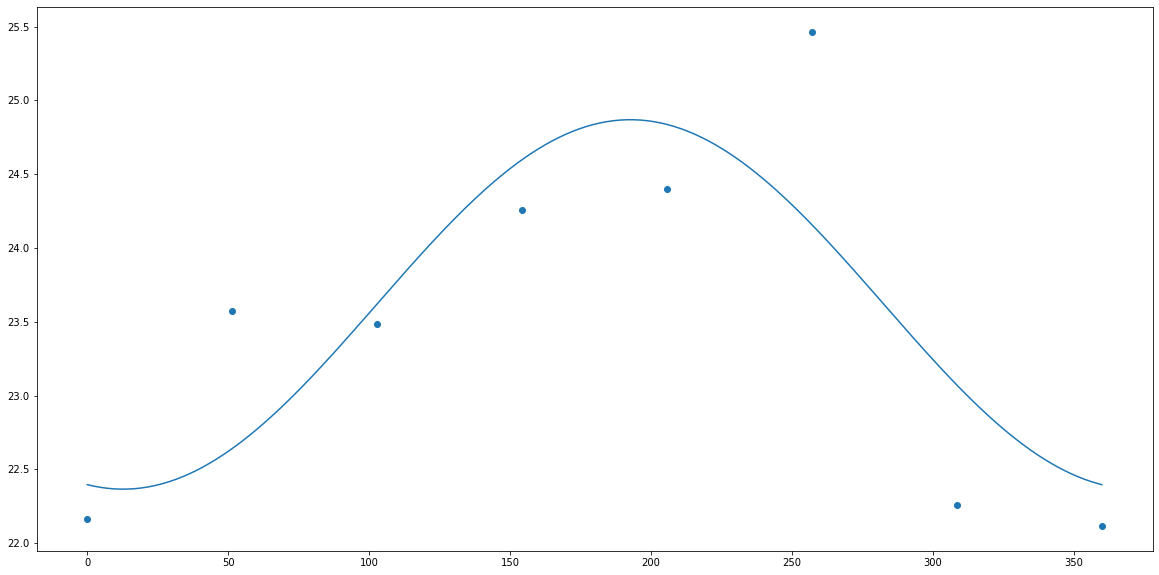

In [87]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline
from scipy import optimize as op

avg_firing_rate = []
var_firing_rate = []

dirc_map = {"up": 0,
            "up_right": 1,
            "right": 2,
            "down_right": 3,
            "down": 4,
            "down_left": 5,
            "left": 6,
            "up_left": 7}

start = "down"
zero_degree = dirc_map[start]


def f1(x, a0, a2, a3):
    return a0 * np.sin(2.*np.pi/360.*x + a2) + a3

# visualize the first viz_channels of each direction

for dirc, idx in dirc_map.items():

    motion_waves = waves_collection[idx]

    num_firings = sum([len(t) for t, _ in motion_waves])
    avg_firing_rate.append(num_firings/(len(motion_waves)*2.))

    avgs = np.array([len(t)/2. for t, _ in motion_waves])
    var_firing_rate.append(np.std(avgs))

plt.figure(figsize=(20, 10))

xs = np.linspace(0, 360, 8)
ys = avg_firing_rate[zero_degree:]+avg_firing_rate[:zero_degree]
plt.scatter(xs, ys)

# p_xs = np.linspace(0, 360, 100)
# cubic_interp = make_interp_spline(xs, ys,)
# p_ys = cubic_interp(p_xs)

y_smoothed = gaussian_filter1d(ys, sigma=1)

# plt.plot(xs, y_smoothed)
# plt.plot(p_xs, p_ys)
# plt.errorbar(xs, ys, var_firing_rate, linestyle='None')

para, _ = op.curve_fit(f1, xs, ys)
a0, a2, a3 = para
fit_x = np.linspace(0, 360, 300)
fit_y = [f1(x, a0, a2, a3) for x in fit_x]
plt.plot(fit_x, fit_y)

plt.savefig('./imgs/tuning_curve.jpg')